## Support Vector Machine

In [1]:
%%html
<style>.container {width: 98%}</style>

In [68]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

from cvxopt import matrix
from cvxopt.solvers import qp

In [327]:
class SVC(BaseEstimator, ClassifierMixin):
    def __init__(self, C: float = 1.0, kernel: callable = None):
        self.C = C
        if kernel is None:
            self.kernel = lambda x1, x2: x1.dot(x2)
        else:
            self.kernel = kernel
        
        self.lagrange_mult = None
        self.X_train = None
        self.y_train = None
    
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> SCV:
        classes = np.unique(y)
        if classes.shape[0] != 2:
            raise ValueError("This has to be a binary classification problem")
        
        n_samples, n_features = X.shape
        X_aug = np.column_stack((np.ones(n_samples), X))
        
        # Build convex optimization matrices
        X = X.astype(float)
        y = y.astype(float)
        
        kernel_matrix = np.empty((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel_matrix[i, j] = self.kernel(X_aug[i, :], X_aug[j, :])
        
        P =  np.outer(y, y) * kernel_matrix
        P = matrix(P)
        q = matrix(-np.ones((n_samples, 1)))
        G = matrix(np.concatenate((np.eye(n_samples), -np.eye(n_samples))))
        h = matrix(np.concatenate((C * np.ones(n_samples), np.zeros(n_samples))))
        A = matrix(y[None, :])
        b = matrix(0.0)
        
        solution = qp(P, q, G, h, A, b, options={"show_progress": False})
        self.lagrange_mult = np.array(solution["x"]).T[0]
        
        self.X_train = X_aug
        self.y_train = y
        
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        n1 = self.X_train.shape[0]
        n2 = X.shape[0]
        
        X_aug = np.column_stack((np.ones(n2), X))
        
        kernel_matrix = np.empty((n1, n2))
        for i in range(n1):
            for j in range(n2):
                kernel_matrix[i, j] = self.kernel(self.X_train[i, :], X_aug[j, :])
                
        y_pred = kernel_matrix * self.lagrange_mult[:, None] * self.y_train[:, None]
        y_pred = np.sum(y_pred, axis=0)
        y_pred = np.sign(y_pred)
        return y_pred
    
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

### Use a simple dataset with 2 classes

In [259]:
data = datasets.load_breast_cancer()
X = data["data"]
y = data["target"]
y[y == 0] = -1

In [304]:
gamma = 0.01
clf = SVC(C=1.0, kernel=lambda a, b: np.exp(-gamma*np.sum((a-b)**2)))  # RBF kernel
clf.fit(X, y)

In [305]:
y_pred = clf.predict(X)
confusion_matrix(y, y_pred)

array([[212,   0],
       [  0, 357]])

### Cross-validated accuracy

In [306]:
np.mean(cross_val_score(clf, X, y, cv=5))

0.8980593075609378

### Visualize decision boundary on moons dataset

In [344]:
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=0)
y[y == 0] = -1

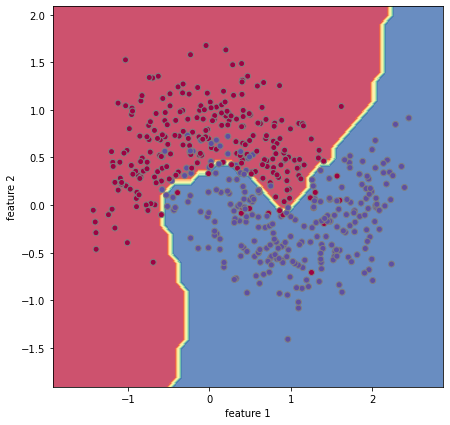

In [346]:
f1, f2 = 0, 1

plt.figure(figsize=(7, 7))

cm = plt.cm.Spectral

h = .1
x_min, x_max = X[:, f1].min() - .5, X[:, f1].max() + .5
y_min, y_max = X[:, f2].min() - .5, X[:, f2].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

gamma = 10.0
clf = SVC(C=1.0, kernel=lambda a, b: np.exp(-gamma*np.sum((a-b)**2)))
clf.fit(X[:, [f1, f2]], y)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

plt.scatter(X[:, f1], X[:, f2], c=y, cmap=cm, edgecolor="grey")

plt.xlabel(f"feature {f1+1}")
plt.ylabel(f"feature {f2+1}")
plt.show()